In [107]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

## Formatting dataset

In [108]:
file_path = os.path.join(os.getcwd(), 'Outcomes.xlsx')

outcomes = pd.read_excel(file_path)
cols = list(outcomes.columns)

outcomes=outcomes[cols[:cols.index('Unnamed: 7')]]
# outcomes=outcomes.fillna(0)
outcomes.rename(columns={'Area_Outcome': 'Date'}, inplace=True)

## Surface level analysis - only current SIBs

In [109]:
def format_raw_data(cs_outcomes):
    current_SIBs = [ 'H&B', 'Camden', 'Enfield', 'WLA', 'Shropshire', 'TH LD', 'TH SMI']
    cs_outcomes = outcomes[outcomes['SIB'].isin(current_SIBs)].reset_index(drop=True)
    cs_outcomes['Month'] = cs_outcomes['Date'].dt.month
    cs_outcomes['Quarter'] = np.where(cs_outcomes['Date'].dt.month == 4, 'Q1',
                                        np.where(cs_outcomes['Date'].dt.month == 7, 'Q2',
                                                np.where(cs_outcomes['Date'].dt.month == 10, 'Q3','Q4')
                                                )
                                        )

    cs_outcomes['FY'] = np.where(cs_outcomes['Quarter'].isin(['Q1', 'Q2', 'Q3']), cs_outcomes['Date'].dt.year,cs_outcomes['Date'].dt.year -1)
    cs_outcomes['FY'] = cs_outcomes['FY'].astype(str)
    cs_outcomes['FY Date'] = cs_outcomes['FY'] + cs_outcomes['Quarter']
    return cs_outcomes

cs_outcomes = format_raw_data(outcomes)
cs_outcomes.head()

,Date,SIB,Referrals,Engagements,Job Starts,Sustainments,Number of ES,Month,Quarter,FY,FY Date
0,2016-01-01,H&B,NaN,NaN,NaN,NaN,NaN,1,Q4,2015,2015Q4
1,2016-04-01,H&B,NaN,NaN,NaN,NaN,NaN,4,Q1,2016,2016Q1
2,2016-07-01,H&B,NaN,NaN,NaN,NaN,NaN,7,Q2,2016,2016Q2
3,2016-10-01,H&B,NaN,NaN,NaN,NaN,NaN,10,Q3,2016,2016Q3
4,2017-01-01,H&B,NaN,NaN,NaN,NaN,NaN,1,Q4,2016,2016Q4


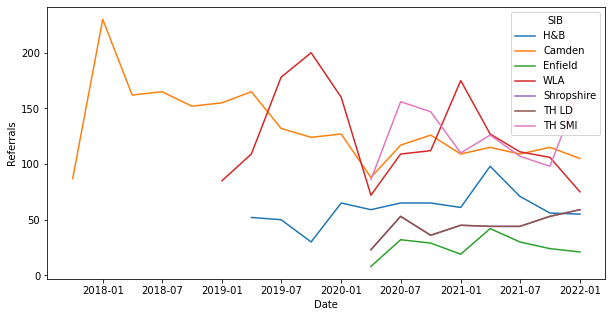

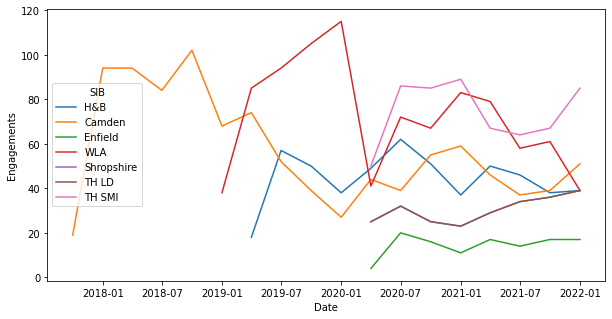

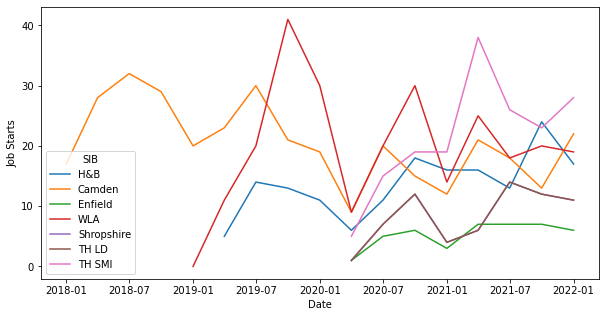

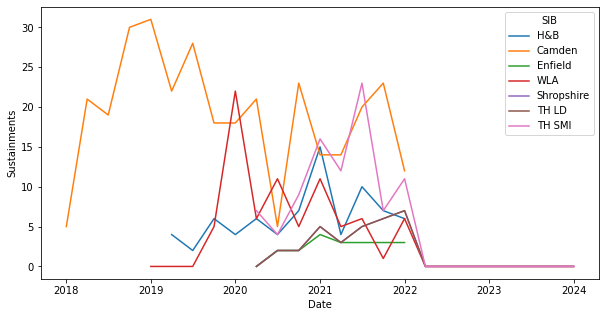

In [110]:
cols = list(cs_outcomes.columns)
for c in cols[2:6]:
    plt.figure(figsize=(10,5))
    sns.lineplot(x='Date', y=c, data=cs_outcomes, hue='SIB')

In [111]:
## creating FY totals

def create_analysis_columns(cs_outcomes):
    cols = list(cs_outcomes.columns)
    for c in cols[2:6]:
        cs_outcomes['FY ' + c] = cs_outcomes[c].groupby([cs_outcomes['FY'], cs_outcomes['SIB']]).transform('sum')
        cs_outcomes['FY Qly Avg ' + c] = cs_outcomes[c].groupby([cs_outcomes['FY'], cs_outcomes['SIB']]).transform('mean')    
        cs_outcomes['FY Low ' + c] = cs_outcomes[c].groupby([cs_outcomes['FY'], cs_outcomes['SIB']]).transform('min')
        cs_outcomes['FY High ' + c] = cs_outcomes[c].groupby([cs_outcomes['FY'], cs_outcomes['SIB']]).transform('max')


        cs_outcomes[c + ' Indexed to avg fyq performance'] = cs_outcomes[c]/cs_outcomes['FY Qly Avg ' + c]
        cs_outcomes[c + ' % of fy total'] = cs_outcomes[c]/cs_outcomes['FY ' + c]
        cs_outcomes[c + ' Indexed to fy min'] = cs_outcomes[c]/cs_outcomes['FY Low ' + c]
        cs_outcomes[c + ' Indexed to fy max'] = cs_outcomes[c]/cs_outcomes['FY High ' + c]

        cs_outcomes[c + ' Per ES'] = cs_outcomes[c]/cs_outcomes['Number of ES']

        cs_outcomes['FY Qly Avg ' + c + ' PES'] = cs_outcomes[c + ' Per ES'].groupby([cs_outcomes['FY'], cs_outcomes['SIB']]).transform('mean')    
        cs_outcomes['FY Low ' + c + ' PES'] = cs_outcomes[c + ' Per ES'].groupby([cs_outcomes['FY'], cs_outcomes['SIB']]).transform('min')
        cs_outcomes['FY High ' + c + ' PES'] = cs_outcomes[c + ' Per ES'].groupby([cs_outcomes['FY'], cs_outcomes['SIB']]).transform('max')

        cs_outcomes[c + ' Indexed to avg fyq PES'] = cs_outcomes[c + ' Per ES']/cs_outcomes['FY Qly Avg ' + c + ' PES']
        cs_outcomes[c + ' Indexed to fy min PES'] = cs_outcomes[c + ' Per ES']/cs_outcomes['FY Low ' + c + ' PES']
        cs_outcomes[c + ' Indexed to fy max PES'] = cs_outcomes[c + ' Per ES']/cs_outcomes['FY High ' + c + ' PES']
        
        if c == 'Referrals':
            pass
        else:
            denominator = cols.index(c) - 1
            numerator = cols.index(c)

            cs_outcomes[cols[denominator][0] + ' to ' + c[0] + ' Quarterly Conversion Rate'] = cs_outcomes[c]/cs_outcomes[cols[denominator]]

    return cs_outcomes


cs_outcomes = create_analysis_columns(cs_outcomes)

## 1. Current MHEP SIBs Only

### 1.1 Barplot of average quarterly indexed performance (to avg fy performance) levels by quarter

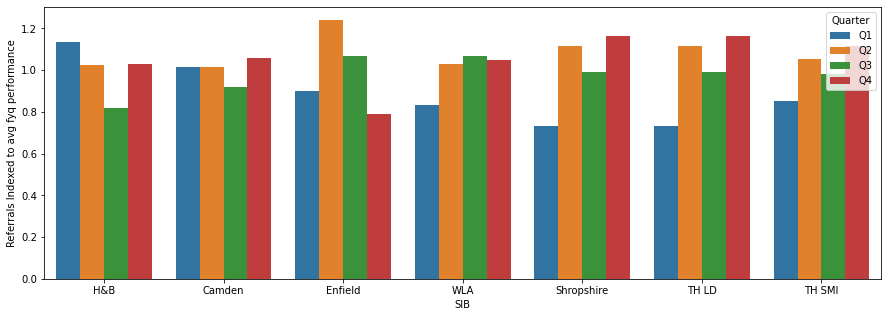

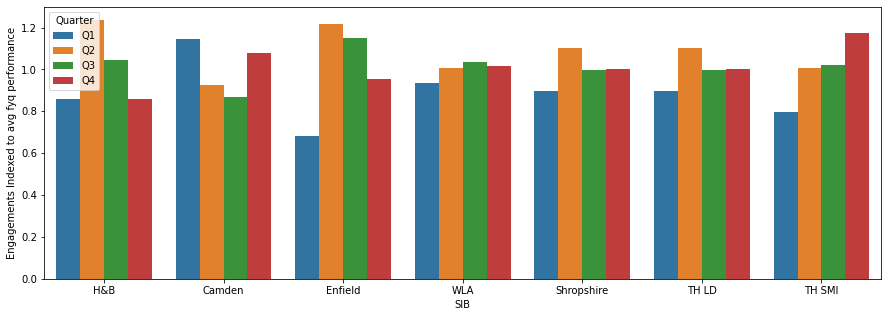

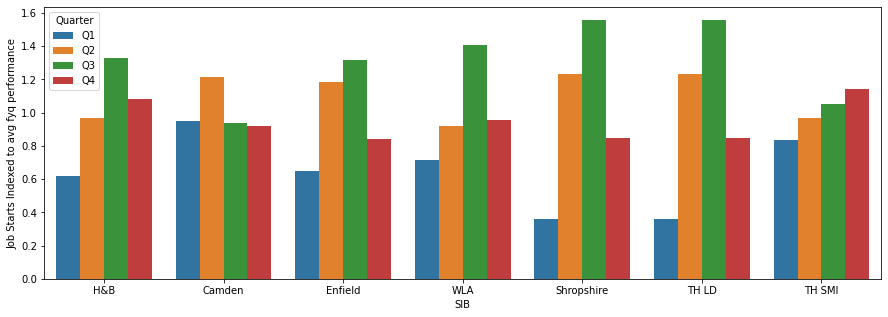

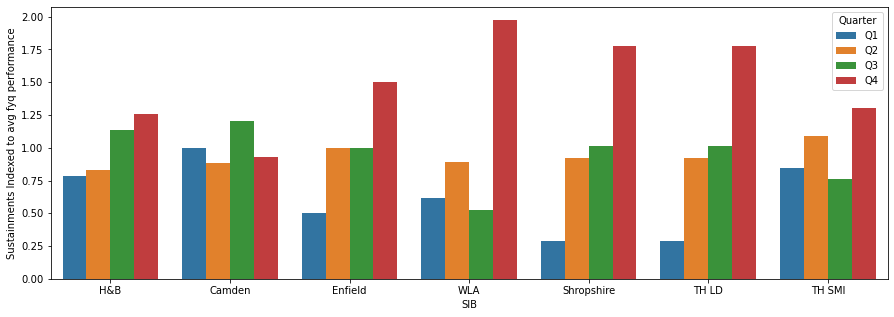

In [112]:
## use list comprehension to create y_value lists

cols = list(cs_outcomes.columns)
y_values = [x for x in cols if 'Indexed to avg fyq performance' in x]
hue_order = ['Q1', 'Q2', 'Q3', 'Q4']

for y in y_values:
    plt.figure(figsize=(15,5))
    sns.barplot(x='SIB', y=y, data=cs_outcomes, hue = 'Quarter', hue_order = hue_order, ci=None)

### 1.2 Same as above but per ES

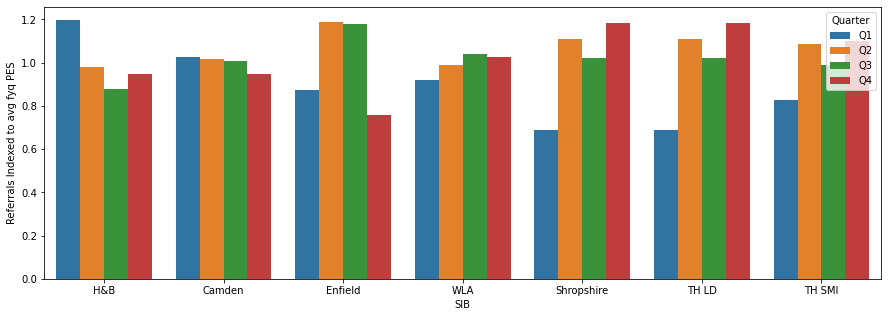

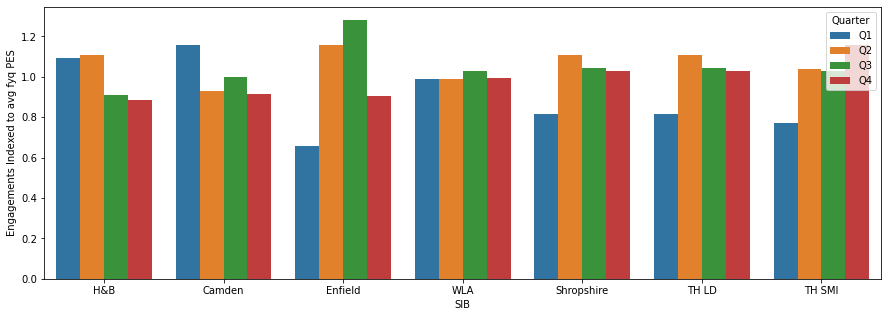

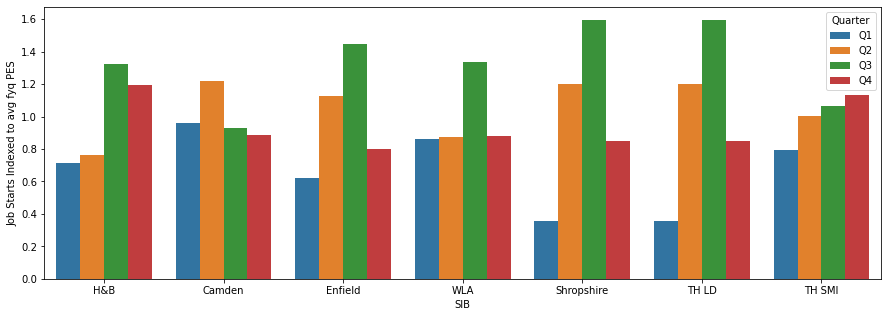

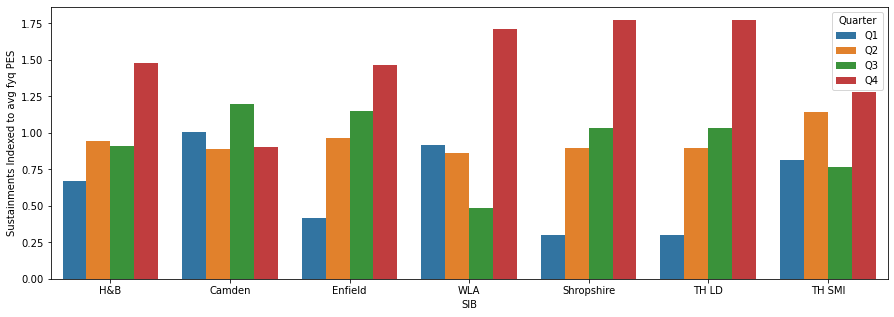

In [113]:
cols = list(cs_outcomes.columns)
y_values = [x for x in cols if 'Indexed to avg fyq PES' in x]

for y in y_values:
    plt.figure(figsize=(15,5))
    sns.barplot(x='SIB', y=y, data=cs_outcomes, hue = 'Quarter', hue_order = hue_order, ci=None)
    
plt.show()

### Quick look at in quarter conversion rates

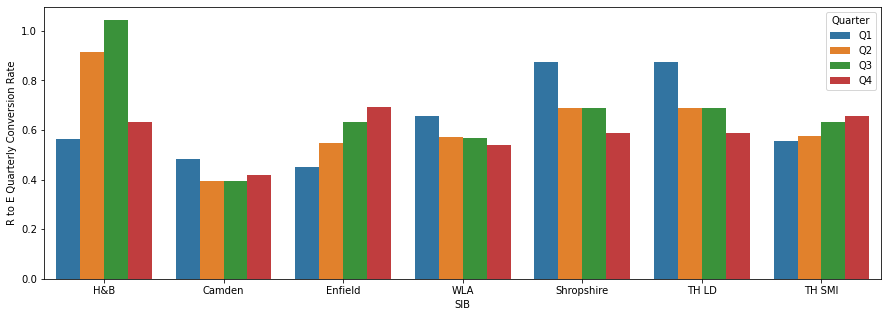

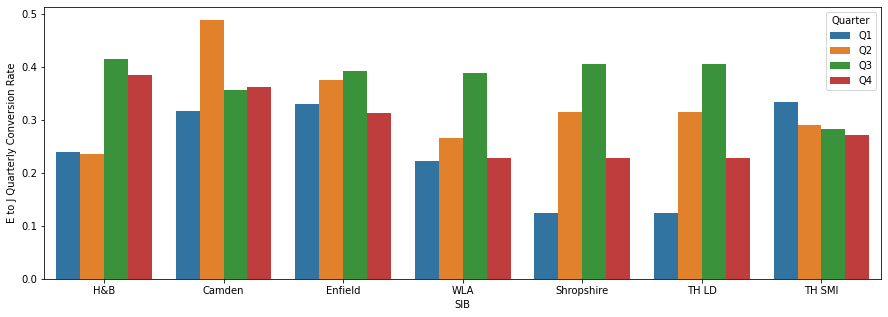

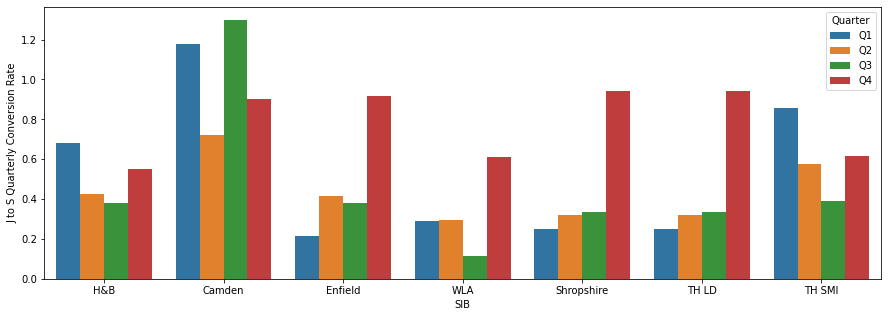

In [114]:
cols = list(cs_outcomes.columns)
y_values = [x for x in cols if 'Conversion Rate' in x]

for y in y_values:
    plt.figure(figsize=(15,5))
    sns.barplot(x='SIB', y=y, data=cs_outcomes, hue = 'Quarter', hue_order = hue_order, ci=None)
    
plt.show()

## 2. Looking at all SIBs (not just current)

In [115]:
def format_raw_data(cs_outcomes):
    cs_outcomes['Month'] = cs_outcomes['Date'].dt.month
    cs_outcomes['Quarter'] = np.where(cs_outcomes['Date'].dt.month == 4, 'Q1',
                                        np.where(cs_outcomes['Date'].dt.month == 7, 'Q2',
                                                np.where(cs_outcomes['Date'].dt.month == 10, 'Q3','Q4')
                                                )
                                        )

    cs_outcomes['FY'] = np.where(cs_outcomes['Quarter'].isin(['Q1', 'Q2', 'Q3']), cs_outcomes['Date'].dt.year,cs_outcomes['Date'].dt.year -1)
    cs_outcomes['FY'] = cs_outcomes['FY'].astype(str)
    cs_outcomes['FY Date'] = cs_outcomes['FY'] + cs_outcomes['Quarter']
    
    cs_outcomes = cs_outcomes.dropna(axis=0, subset = ['Referrals', 'Engagements', 'Job Starts', 'Sustainments'])
    
    
    return all_outcomes

all_outcomes = format_raw_data(outcomes)
all_outcomes = create_analysis_columns(all_outcomes)

### 2.1 Barplot of average quarterly indexed performance (to avg fy performance) levels by quarter

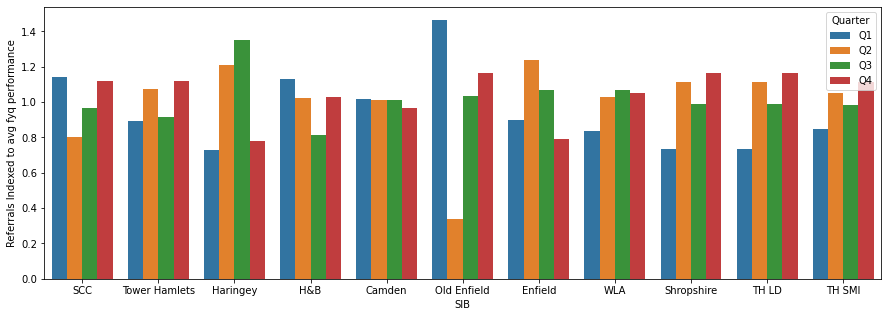

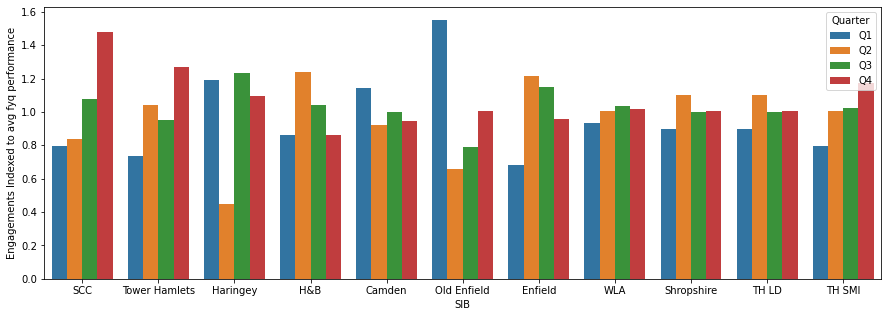

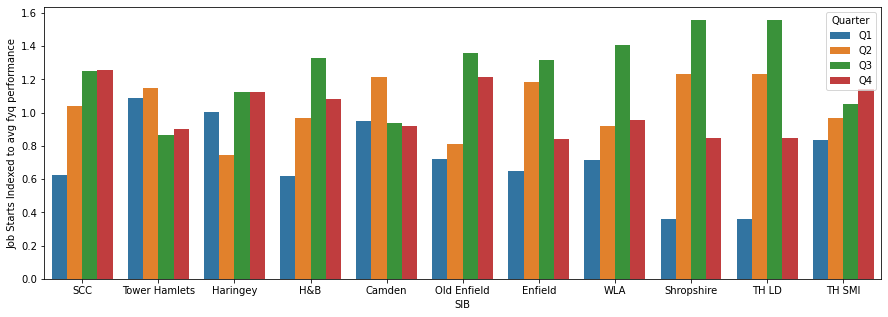

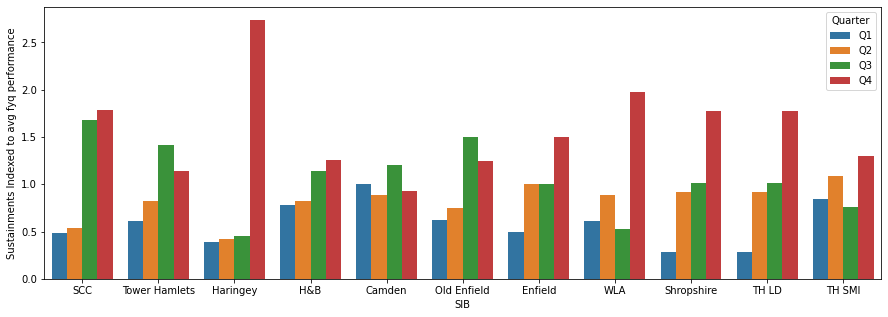

In [116]:
cols = list(all_outcomes.columns)
y_values = [x for x in cols if 'Indexed to avg fyq performance' in x]

for y in y_values:
    plt.figure(figsize=(15,5))
    sns.barplot(x='SIB', y=y, data=all_outcomes, hue = 'Quarter', hue_order = hue_order, ci=None)

### Quick look at in-quarter conversion rates

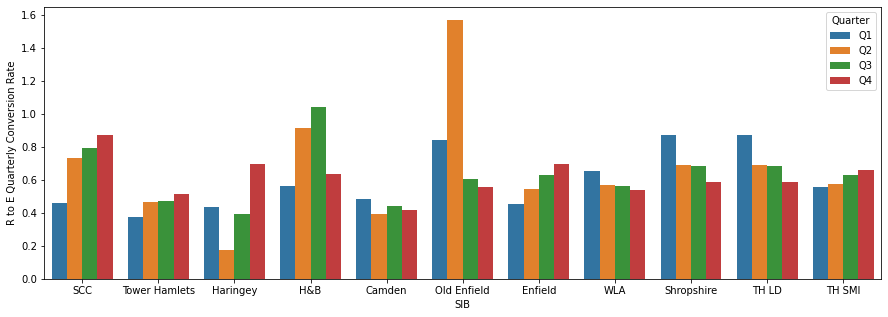

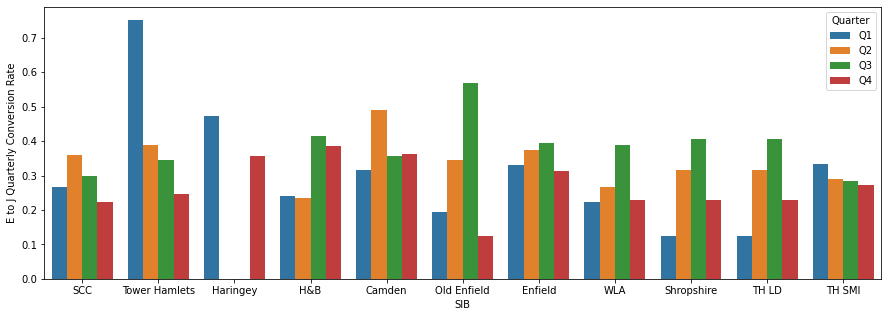

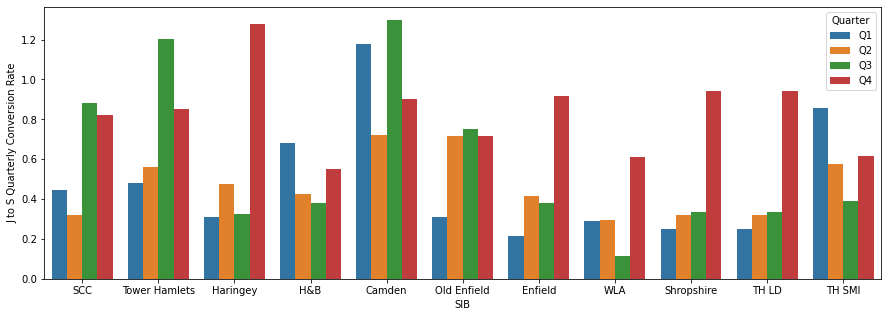

In [117]:
cols = list(all_outcomes.columns)
y_values = [x for x in cols if 'Conversion Rate' in x]

for y in y_values:
    plt.figure(figsize=(15,5))
    sns.barplot(x='SIB', y=y, data=all_outcomes, hue = 'Quarter', hue_order = hue_order, ci=None)
    
plt.show()

## Appendices

### Appendix 1 - % of FY Total achieved per FQ

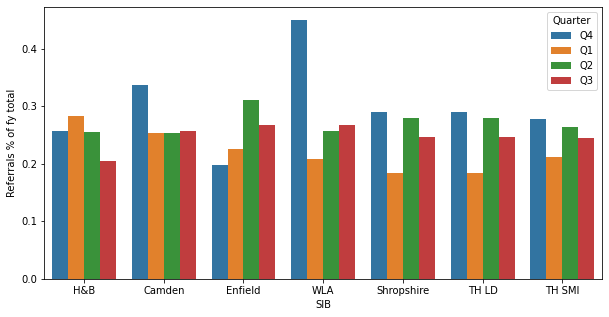

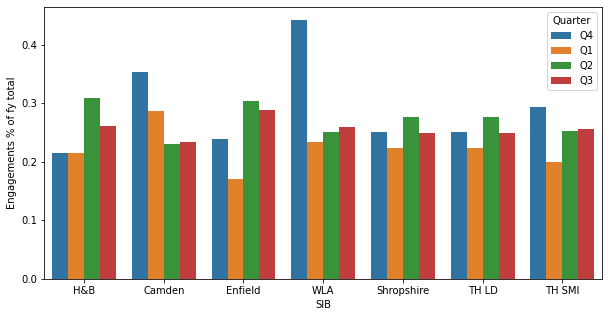

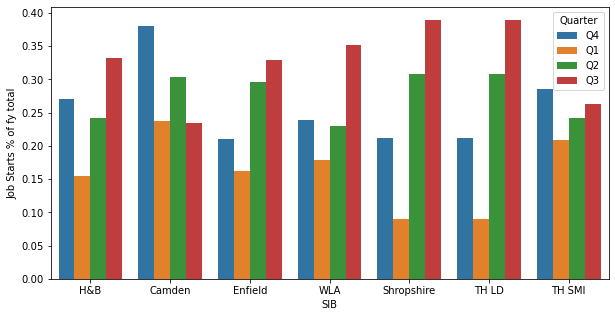

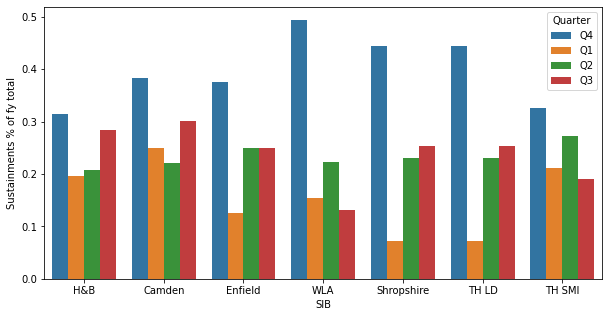

In [88]:
cols = list(cs_outcomes.columns)
y_values = [x for x in cols if '% of fy total' in x]

for y in y_values:
    plt.figure(figsize=(10,5))
    sns.barplot(x='SIB', y=y, data=cs_outcomes, hue = 'Quarter', ci=None)

### Appendix 2 - Quarterly Performance indexed to FY Quarterly Minimum

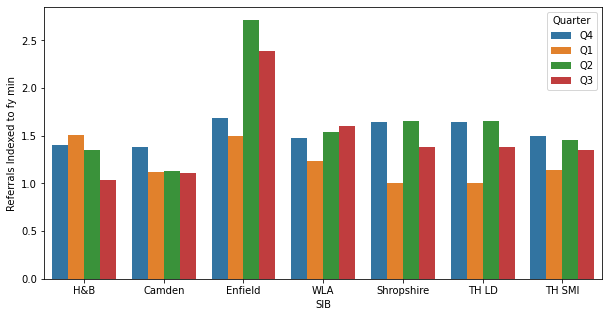

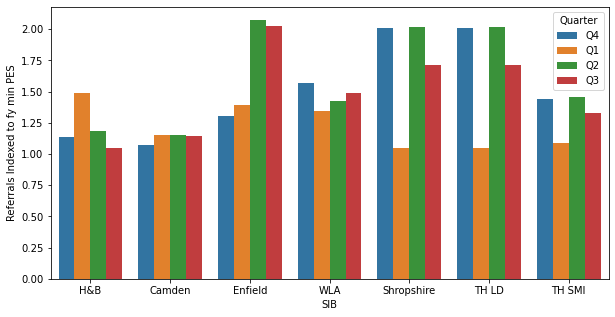

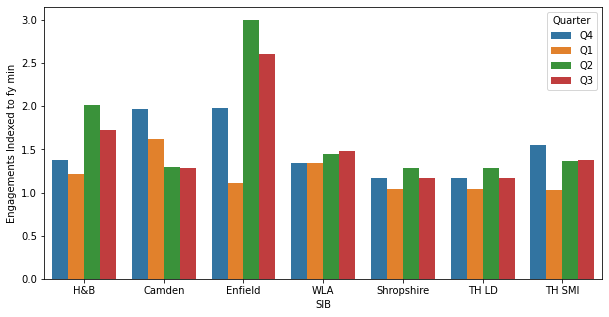

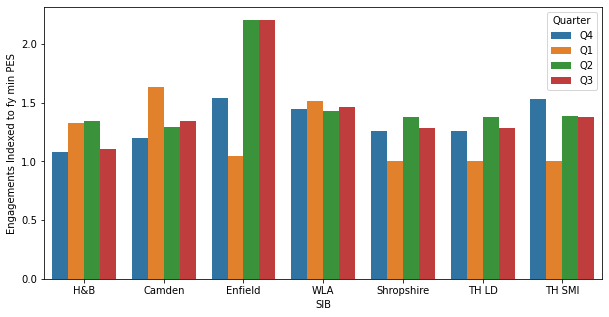

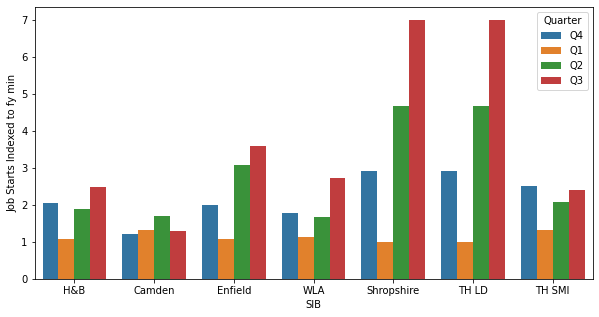

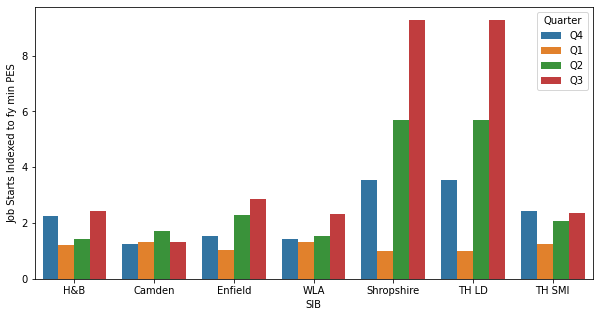

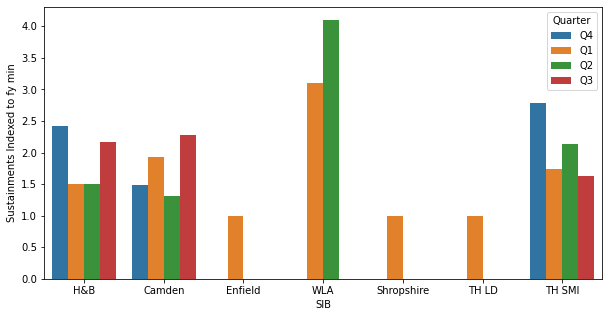

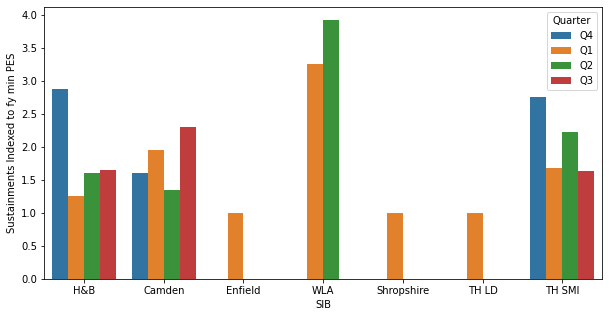

In [89]:
cols = list(cs_outcomes.columns)
y_values = [x for x in cols if 'Indexed to fy min' in x]

for y in y_values:
    plt.figure(figsize=(10,5))
    sns.barplot(x='SIB', y=y, data=cs_outcomes, hue = 'Quarter', ci=None)

### Appendix 3 - Indexed performance to FY Quarterly Maximum

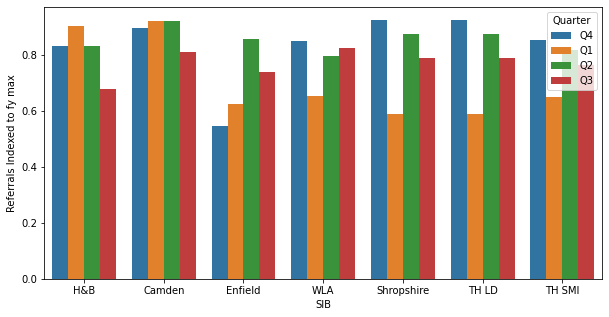

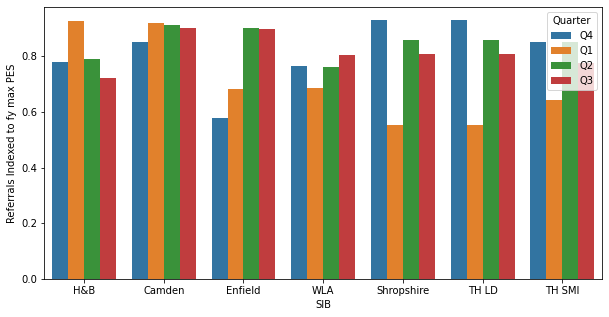

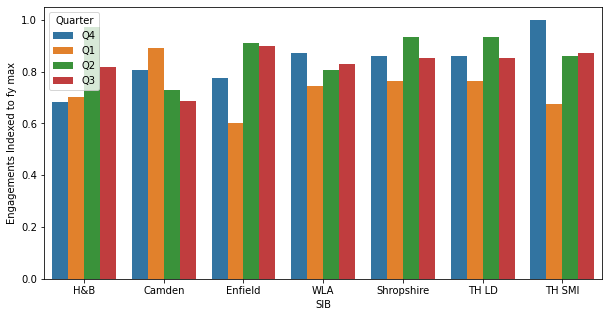

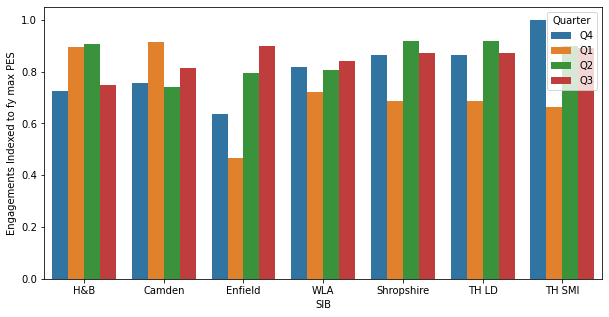

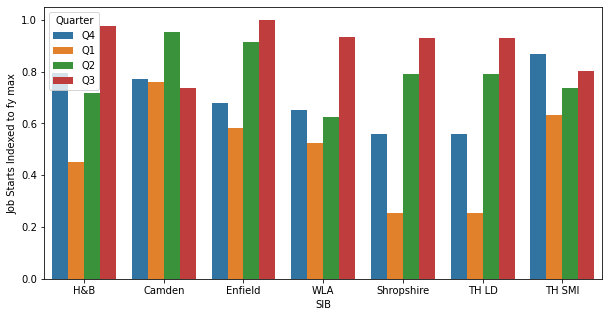

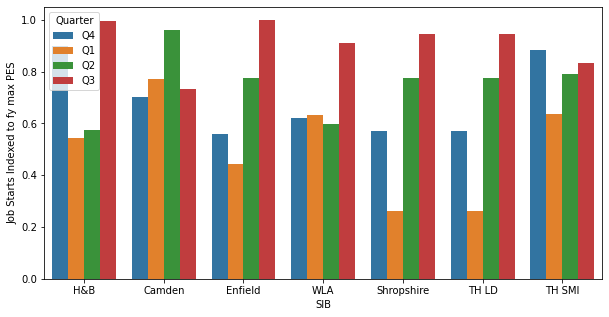

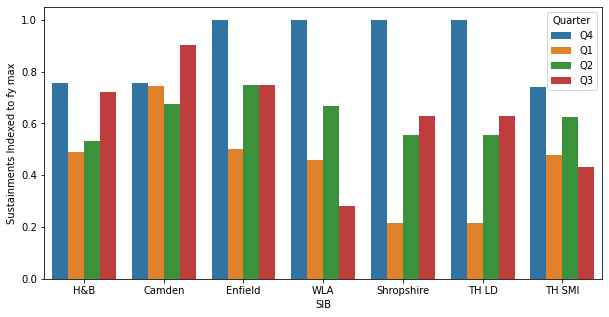

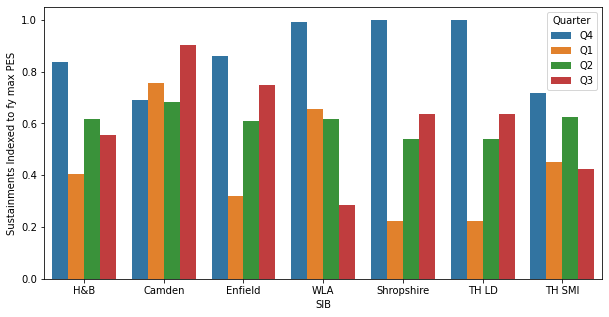

In [90]:
cols = list(cs_outcomes.columns)
y_values = [x for x in cols if 'Indexed to fy max' in x]

for y in y_values:
    plt.figure(figsize=(10,5))
    sns.barplot(x='SIB', y=y, data=cs_outcomes, hue = 'Quarter', ci=None)